In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

Data info:

Context
After watching Somm (a documentary on master sommeliers) I wondered how I could create a predictive model to identify wines through blind tasting like a master sommelier would. The first step in this journey was gathering some data to train a model. I plan to use deep learning to predict the wine variety using words in the description/review. The model still won't be able to taste the wine, but theoretically it could identify the wine based on a description that a sommelier could give. If anyone has any ideas on how to accomplish this, please post them!

License: CC BY-NC-SA 4.0

Link: https://www.kaggle.com/datasets/zynicide/wine-reviews

In [9]:
dp=pd.read_csv('wine-reviews.csv',usecols=['country', 'description', 'designation', 'points', 'price', 'province', 'variety', 'winery','title'])

In [10]:
dp=dp.dropna(subset=['description','points'])

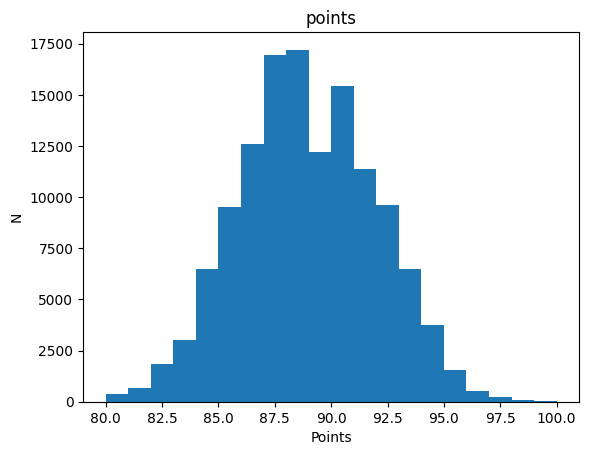

In [11]:
plt.hist(dp.points, bins=20)
plt.title('points')
plt.ylabel('N')
plt.xlabel('Points')
plt.show()

In [12]:
dp['label']=(dp.points >= 90).astype(int)

In [19]:
dp=dp[['description','label']]

In [20]:
dp.head()

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [21]:
dp.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [24]:
train, val, test=np.split(dp.sample(frac=1), [int(0.8*len(dp)),int(0.9*len(dp))]) #dp.sapmle(frac=1) will shuufle the data in dataframe taken

In [25]:
len(train), len(test), len(val)

(103976, 12998, 12997)

In [34]:
def dp_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df=dataframe.copy()
  labels=df.pop('label')
  df=df['description']
  ds=tf.data.Dataset.from_tensor_slices((df,labels))
  if shuffle:
    ds=ds.shuffle(buffer_size=len(dataframe))
  ds=ds.batch(batch_size)
  ds=ds.prefetch(tf.data.AUTOTUNE)
  return ds



In [35]:
train_data=dp_to_dataset(train)
valid_data=dp_to_dataset(val)
test_data=dp_to_dataset(test)

#Embedding + Model

In [39]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2" #model:nnlm-en-dim50
hub_layer=hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [40]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.4111718 , -0.17755562,  0.06047744, ..., -0.26823413,
         0.00170818,  0.00480649],
       [ 0.4231516 , -0.10925434,  0.06897243, ..., -0.09817774,
        -0.35517076, -0.0843456 ],
       [ 0.346446  , -0.16482356,  0.18419868, ..., -0.07594306,
        -0.2596325 ,  0.06816825],
       ...,
       [ 0.236482  , -0.26878995,  0.02381759, ..., -0.09554718,
        -0.1817231 , -0.01551142],
       [ 0.44920698, -0.2259502 ,  0.16296183, ...,  0.06730193,
        -0.28518876, -0.20063256],
       [ 0.29118884, -0.1649019 ,  0.04561856, ...,  0.01566892,
        -0.14367527, -0.07064872]], dtype=float32)>

In [63]:
model= tf.keras.Sequential()

model.add(hub_layer)
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [64]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
)

In [65]:
model.evaluate(train_data)

102/102 [==============================] - 19s 181ms/step - loss: 0.6805 - accuracy: 0.6230


[0.6804602146148682, 0.622970700263977]

In [66]:
model.evaluate(valid_data)

13/13 [==============================] - 3s 199ms/step - loss: 0.6805 - accuracy: 0.6224


[0.6805044412612915, 0.622374415397644]

In [67]:
history=model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
102/102 [==============================] - 144s 1s/step - loss: 0.3927 - accuracy: 0.8159 - val_loss: 0.3749 - val_accuracy: 0.8328
Epoch 2/10
102/102 [==============================] - 157s 2s/step - loss: 0.2983 - accuracy: 0.8708 - val_loss: 0.3705 - val_accuracy: 0.8366
Epoch 3/10
102/102 [==============================] - 145s 1s/step - loss: 0.2752 - accuracy: 0.8838 - val_loss: 0.3805 - val_accuracy: 0.8408
Epoch 4/10
102/102 [==============================] - 145s 1s/step - loss: 0.2542 - accuracy: 0.8943 - val_loss: 0.3854 - val_accuracy: 0.8390
Epoch 5/10
102/102 [==============================] - 144s 1s/step - loss: 0.2308 - accuracy: 0.9070 - val_loss: 0.4106 - val_accuracy: 0.8361
Epoch 6/10
102/102 [==============================] - 159s 2s/step - loss: 0.2056 - accuracy: 0.9186 - val_loss: 0.4317 - val_accuracy: 0.8374
Epoch 7/10
102/102 [==============================] - 185s 2s/step - loss: 0.1789 - accuracy: 0.9313 - val_loss: 0.4606 - val_accuracy: 0.8346

In [68]:
model.evaluate(test_data)

13/13 [==============================] - 3s 221ms/step - loss: 0.6067 - accuracy: 0.8339


[0.6067492365837097, 0.8338975310325623]

#LSTM

In [70]:
encoder=tf.keras.layers.TextVectorization(max_tokens=2000) #max tokens for remembering is 2000

encoder.adapt(train_data.map(lambda text, label: text))

In [71]:
vocab= np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [77]:
model1= tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')

])


In [79]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
)

In [80]:
model1.evaluate(train_data)
model1.evaluate(valid_data)

13/13 [==============================] - 2s 141ms/step - loss: 0.6930 - accuracy: 0.5230


[0.6929686665534973, 0.5229668617248535]

In [81]:
history=model1.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
102/102 [==============================] - 46s 407ms/step - loss: 0.5373 - accuracy: 0.7193 - val_loss: 0.3794 - val_accuracy: 0.8279
Epoch 2/10
102/102 [==============================] - 47s 454ms/step - loss: 0.3676 - accuracy: 0.8353 - val_loss: 0.3577 - val_accuracy: 0.8370
Epoch 3/10
102/102 [==============================] - 41s 397ms/step - loss: 0.3503 - accuracy: 0.8437 - val_loss: 0.3547 - val_accuracy: 0.8380
Epoch 4/10
102/102 [==============================] - 41s 405ms/step - loss: 0.3430 - accuracy: 0.8461 - val_loss: 0.3526 - val_accuracy: 0.8347
Epoch 5/10
102/102 [==============================] - 41s 403ms/step - loss: 0.3389 - accuracy: 0.8474 - val_loss: 0.3535 - val_accuracy: 0.8357
Epoch 6/10
102/102 [==============================] - 41s 401ms/step - loss: 0.3351 - accuracy: 0.8490 - val_loss: 0.3502 - val_accuracy: 0.8386
Epoch 7/10
102/102 [==============================] - 42s 406ms/step - loss: 0.3324 - accuracy: 0.8494 - val_loss: 0.3482 - val_ac

In [82]:
model1.evaluate(test_data)

13/13 [==============================] - 2s 173ms/step - loss: 0.3593 - accuracy: 0.8399


[0.35932472348213196, 0.8398984670639038]